Autogen version: 0.5.7
Max SP TFLOP/s with FMA 25.068
Max DP TFLOP/s with FMA 0.392
Max SP TFLOP/s w/out FMA 12.534
Max DP TFLOP/s w/out FMA 0.196
Max TINTOP/s 12.534
SP Balance Point is at: 32.97 flop/byte
DP Balance Point is at: 0.52 flop/byte
INT Balance Point is at: 16.49 intop/byte

These values get passed as LLM context so the model can infer about rooflines:
Peak SP GFLOP/s 25067.52 with FMA
Peak DP GFLOP/s 391.68 with FMA
Peak GINTOP/s 12533.76 with FMA
scraped and pruned CUDA programs count 297
scraped and pruned OMP  programs count 242


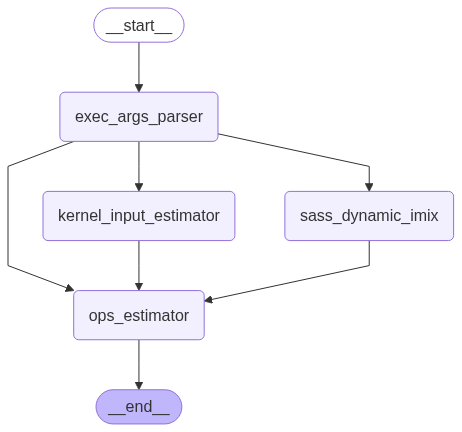

In [1]:
from roofline_utils import *
from langchain.globals import set_verbose
set_verbose(True)

from langgraph_cuda_static_analysis import *

import re
from collections import Counter

import time
import argparse
import sys
import os

In [2]:
# ### Open the Trin/Val Data CSV Files
dtypes['language'] = 'string'
dtypes['numTokens'] = np.int64
dtypes['kernelCode'] = 'string'
dtypes['kernelSASS'] = 'string'
dtypes['isBB'] = np.int64
dtypes['class'] = 'string'
dtypes['answer'] = 'string'

reasoning_models = ['o3', 'o1', 'o4']

def is_reasoning_model(modelName):
    # the last part of the model name is the model name
    # example: openai/o3-mini-2024-11-20 is o3-mini-2024-11-20
    mName = modelName.split('/')[-1]
    for m in reasoning_models:
        if m in mName:
            return True
    return False

In [3]:

trainDF = pd.read_csv('train-dataset-balanced.csv', quotechar='"', dtype=dtypes)
valDF = pd.read_csv('validation-dataset-balanced.csv', quotechar='"', dtype=dtypes)

trainDF['isTrain'] = 1
valDF['isTrain'] = 0

df = pd.concat([trainDF, valDF], ignore_index=True)

# keep only the CUDA codes
df = df[df['language'] == 'CUDA']

print(df.shape)

(170, 24)


In [4]:
# Static IMIX Extractor Function
def sass_imix_analysis(sass_code: str) -> dict:
    """
    Ingests CUDA SASS assembly code as a string and returns a count of each instruction type (IMIX).
    Ignores header information from fatbin/elf dumps, counting only actual instructions.

    Parameters:
        sass_code (str): The SASS code as a string.

    Returns:
        dict: A dictionary mapping instruction mnemonics to their counts.
    """
    # Regex to match instruction mnemonics (see previous explanation)
    instr_regex = re.compile(
        r"""^[\s\/\*0-9a-fA-F]*      # optional address and comment
            (?:@\w+\s+)?             # optional predicate (@P0)
            ([A-Z0-9]+\.[A-Z0-9\.]+  # e.g. IMAD.MOV.U32, MUFU.RCP
            |[A-Z0-9]+)              # or just plain (IMAD)
            \b""", 
        re.VERBOSE
    )

    counts = Counter()
    in_code = False
    for line in sass_code.splitlines():
        stripped = line.strip()
        # Detect first instruction line to begin parsing SASS code
        # SASS code lines usually start with '/*' and then an address like '0000'
        if not in_code:
            if re.match(r'^\/\*\s*[0-9a-fA-F]+\s*\*\/', stripped):
                in_code = True
            else:
                continue  # ignore header lines
        # Only process lines that are likely to be instructions (contain ';')
        if ';' in line and not stripped.startswith('.'):
            code = line.split(';')[0]
            m = instr_regex.search(code)
            if m:
                mnemonic = m.group(1)
                counts[mnemonic] += 1
    return dict(counts)

In [5]:
for index, row in df.iterrows():
    #sassCode = row['kernelSASS']

    sass_static_imix_dict = sass_imix_analysis(row['kernelSASS'])
    # sort the dictionary by count in descending order
    sass_static_imix_dict = {k: v for k, v in sorted(sass_static_imix_dict.items(), reverse=True, key=lambda item: item[1])}
    sass_static_imix = ""

    for k,v in sass_static_imix_dict.items():
        sass_static_imix += f"{k}:{v}\n"

    sass_static_imix = sass_static_imix.strip()

    print(sass_static_imix)

    query_data: KernelAnalysisState = {
        "source_code": row['kernelCode'],
        "sass_code": row['kernelSASS'],
        "sass_imix": sass_static_imix,
        "kernel_name": row['Kernel Name'],
        "exec_args": row['exeArgs'],
        "grid_size": row['Grid Size'],
        "block_size": row['Block Size'],
        #"program_name": row['targetName'],
        #"device": row['device'],
        # The following fields are optional and will be filled in by the workflow:
        # "updated_source_code", "kernel_op_estimates", "updated_sass_imix", "final_op_counts"
    }


    result = graph.invoke(query_data)
    print(result['final_op_counts'])

    break


IADD3:33
IMAD:29
IMAD.MOV.U32:26
0:21
IMAD.HI.U32:16
IMAD.X:14
SEL:12
LOP3.LUT:10
NOP:10
IMAD.WIDE:9
ISETP.GE.U32.AND:8
STG.E:8
BRA:7
IMAD.WIDE.U32:7
IMAD.MOV:6
ISETP.GT.U32.AND:6
IABS:6
ISETP.NE.U32.AND:5
IMAD.IADD:5
RA:5
SHF.R.U32.HI:5
ISETP.GE.AND:5
LDG.E.CONSTANT:5
IADD3.X:5
MUFU.RCP:4
SSY:4
ISETP.NE.AND:4
SETP.GTU.AND:4
IMAD.SHL.U32:4
SYNC:4
SHF.R.S32.HI:3
I.FTZ.U32.TRUNC.NTZ:3
MOV:3
SHF.R.U64:3
SHF.L.U64.HI:3
LDG.E:3
I2F.U32.RP:2
S2R:2
ISETP.GT.U32.AND.EX:2
LDC.U8:2
I2FP.F32.S32:2
MUL:2
SETP.GE.AND:2
SGXT.U32:2
I.TRUNC.NTZ:2
IMNMX:2
ISETP.GE.U32.AND.EX:2
LL.REL.NOINC:1
ULDC:1
UIADD3:1
ULDC.64:1
I2F.RP:1
I2F.U64.RP:1
I.U64.TRUNC:1
ISETP.NE.AND.EX:1
RET.REL.NODEC:1
Updated source code:
```cpp
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <chrono>
#include <cuda.h>

template <class T, std::size_t CHANNELS_PER_ITER>
__global__
void resize (
    T *__restrict__ output,
    size_t output_size, int out_height, int out_width,
    const T *__restrict__ input, int in_he